## Importing Necessary libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

## Uploading a dataset

In [32]:
df = pd.read_csv("final_data.csv", index_col="Unnamed: 0")
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,label
0,0,1,-0.104067,0.514274,-0.002879,0.138664,0,0,0,0,...,0.0,0.0,-3.451536,-1.694315,0.0,0.11,0.0,0.0,0.0,0
1,0,1,-0.104067,0.514274,-0.002820,-0.011578,0,0,0,0,...,0.0,0.0,-3.297085,-1.600011,0.0,0.05,0.0,0.0,0.0,0
2,0,1,-0.104067,0.514274,-0.002824,0.014179,0,0,0,0,...,0.0,0.0,-3.142633,-1.505707,0.0,0.03,0.0,0.0,0.0,0
3,0,1,-0.104067,0.514274,-0.002840,0.014179,0,0,0,0,...,0.0,0.0,-2.988182,-1.411403,0.0,0.03,0.0,0.0,0.0,0
4,0,1,-0.104067,0.514274,-0.002842,0.035214,0,0,0,0,...,0.0,0.0,-2.833731,-1.317100,0.0,0.02,0.0,0.0,0.0,0


## Final correlation analysis and selecting necessary columns

In [3]:
correlation_label = df.corr()["label"]

In [4]:
high_correlation = df.columns[abs(correlation_label) > 0.3]

In [5]:
df[high_correlation].corr()["label"]

protocol_type                 -0.616601
logged_in                     -0.795282
count                          0.752978
srv_count                      0.566829
srv_diff_host_rate            -0.364687
dst_host_count                 0.642110
dst_host_same_src_port_rate    0.481458
label                          1.000000
Name: label, dtype: float64

In [6]:
df_final = df[high_correlation]

Final data contains 7 columns: 
* protocol_type
* logged_in
* count
* srv_count 
* srv_diff_host_rate
* dst_host_count
* dst_host_same_src_port_rate

In [7]:
df_subset = df.iloc[np.arange(0, df.shape[0], 10)]

In [8]:
X = df.drop("label", axis=1)
y = df["label"]

<Figure size 1000x600 with 0 Axes>

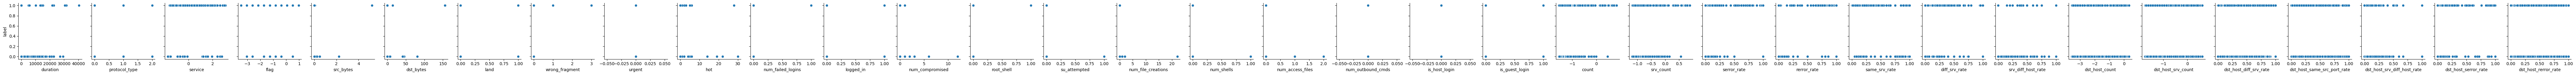

In [9]:
plt.figure(figsize=(10, 6))
sns.pairplot(data=df_subset, x_vars=X.columns, y_vars="label")
plt.show()

After analysis of pair plots, we can assume that 7 columns are enough.

## Train-test splitting

In [10]:
X = df_final.drop("label", axis=1)
y = df_final["label"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

In [12]:
X.shape

(494021, 7)

In [13]:
y.value_counts()

label
1    396743
0     97278
Name: count, dtype: int64

## Auto-Encoder Implementation

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
torch.cuda.empty_cache()

In [15]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
training_data = df_final[df_final["label"] == 0]

In [17]:
training_data.drop("label", axis=1, inplace=True)

/tmp/ipykernel_13107/1902115608.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.drop("label", axis=1, inplace=True)


In [18]:
training_array = training_data.to_numpy()
X_train, X_val = train_test_split(training_array, train_size=0.75, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32).to(device=device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device=device)

In [23]:
class Autoencoder(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(7, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 7),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(7, 16), 
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 7)
        )
    
    def forward(self, x):

        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded        

In [24]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
model = model.to(device=device)

In [26]:
training_losses = []
validation_losses = []

num_epochs = 250
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train)
    training_loss = criterion(outputs, X_train)

    training_loss.backward()
    optimizer.step()

    training_losses.append(training_loss)

    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, X_val)
        validation_losses.append(val_loss)

    print(f"Epoch {epoch}: Training Loss => {training_loss}; Validation Loss: {val_loss}")

Epoch 0: Training Loss => 1.3341327905654907; Validation Loss: 1.3232344388961792
Epoch 1: Training Loss => 1.3250583410263062; Validation Loss: 1.3140398263931274
Epoch 2: Training Loss => 1.3158509731292725; Validation Loss: 1.304720401763916
Epoch 3: Training Loss => 1.3065190315246582; Validation Loss: 1.2953020334243774
Epoch 4: Training Loss => 1.2970877885818481; Validation Loss: 1.2857825756072998
Epoch 5: Training Loss => 1.287555456161499; Validation Loss: 1.27618408203125
Epoch 6: Training Loss => 1.2779443264007568; Validation Loss: 1.2665119171142578
Epoch 7: Training Loss => 1.268259882926941; Validation Loss: 1.2567424774169922
Epoch 8: Training Loss => 1.2584775686264038; Validation Loss: 1.246856689453125
Epoch 9: Training Loss => 1.2485789060592651; Validation Loss: 1.2368569374084473
Epoch 10: Training Loss => 1.238566279411316; Validation Loss: 1.2267425060272217
Epoch 11: Training Loss => 1.2284390926361084; Validation Loss: 1.2165050506591797
Epoch 12: Training Lo

In [27]:
for i in range (num_epochs):
    training_losses[i] = training_losses[i].cpu()
    training_losses[i] = training_losses[i].detach().numpy()

    validation_losses[i] = validation_losses[i].cpu()
    validation_losses[i] = validation_losses[i].detach().numpy()

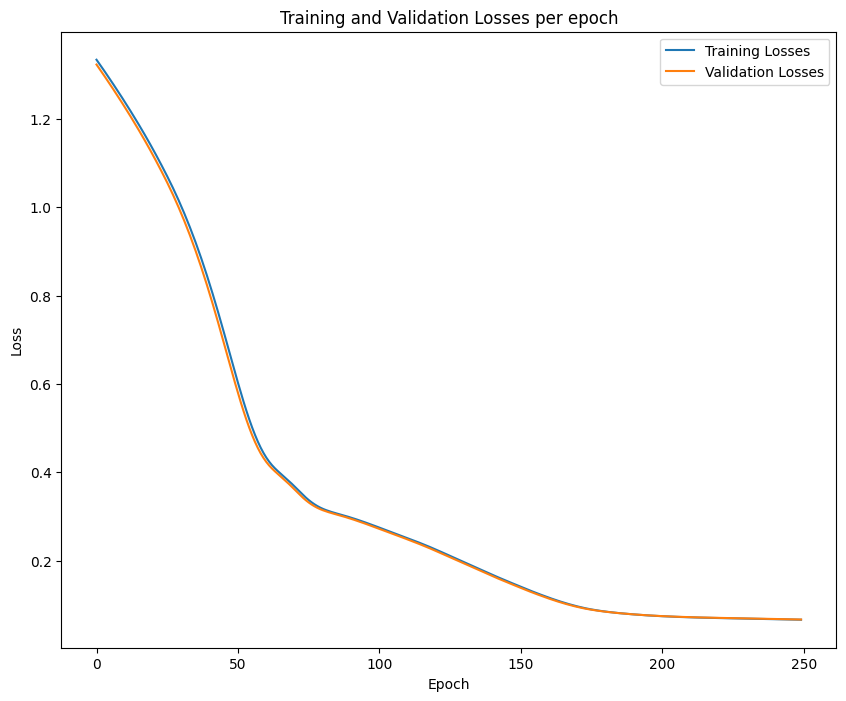

In [28]:
plt.figure(figsize=(10, 8))
plt.plot(training_losses, label="Training Losses")
plt.plot(validation_losses, label="Validation Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Losses per epoch")
plt.show()

In [29]:
torch.save(model, "autoencoder_anomaly_detection.pth")

In [31]:
training_data

,protocol_type,logged_in,count,srv_count,srv_diff_host_rate,dst_host_count,dst_host_same_src_port_rate
0,1,1,-1.521417,-1.156640,0.00,-3.451536,0.11
1,1,1,-1.521417,-1.156640,0.00,-3.297085,0.05
2,1,1,-1.521417,-1.156640,0.00,-3.142633,0.03
3,1,1,-1.530800,-1.164760,0.00,-2.988182,0.03
4,1,1,-1.530800,-1.164760,0.00,-2.833731,0.02
...,...,...,...,...,...,...,...
494016,1,1,-1.540183,-1.168819,0.40,-2.262261,0.01
494017,1,1,-1.530800,-1.164760,0.00,-3.497871,0.17
494018,1,1,-1.530800,-1.116043,0.17,-3.343420,0.06
494019,1,1,-1.530800,-1.140401,0.17,-3.188969,0.04
